<a href="https://colab.research.google.com/github/NeevSabhani/Data-Science/blob/main/Unit5/NeevSabhUnit5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

#**Unit 5 Project: Age vs Insurance Costs**


In today’s world, where healthcare costs are skyrocketing, insurance has become a crucial part of managing financial security and well-being. It’s something almost everyone relies on to protect themselves from unexpected medical expenses, but have you ever wondered how insurance companies decide how much to charge? One of the biggest factors is age, which makes sense since our healthcare needs change as we grow older. Younger people generally require fewer medical services, while older individuals tend to face higher healthcare costs due to age-related conditions. I thought it would be interesting to dive into this topic because it’s something that affects everyone at different stages of life. Whether you're a young adult buying your first policy or someone planning for retirement, insurance charges based on age can have a big impact on your finances.

Because of this relevance in our lives, I thought it would be interesting and fun to dive deeper and model insurance costs as you age.

##**The Data**


In [ ]:
SalesDataUrl = '/content/insurance[1].csv'
SalesData = pd.read_csv(SalesDataUrl)
SalesData = SalesData[['age', 'charges']]

# Cleaning the Data
SalesData = SalesData.dropna(subset=['age', 'charges'])  # Drop rows where age or charges is null
SalesData = SalesData[SalesData['charges'] <= (500 * SalesData['age'])]    # Filter rows where charges > 20,000
SalesData = SalesData[SalesData['charges'] <= 17500]

# Resetting the index after cleaning
SalesData = SalesData.reset_index(drop=True)

SalesData


,age,charges
0,18,1725.5523
1,28,4449.4620
2,32,3866.8552
3,31,3756.6216
4,46,8240.5896
...,...,...
972,52,11411.6850
973,50,10600.5483
974,18,2205.9808
975,18,1629.8335


<Axes: xlabel='age', ylabel='charges'>

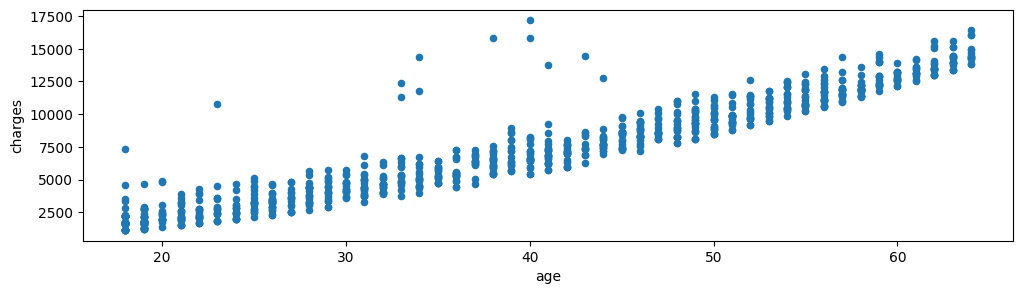

In [ ]:
SalesData.plot(x="age", y="charges", figsize=(12, 3), kind="scatter")

Just by looking at the plot of all of our data points, we can see that there is a very, very obvious increasing linear pattern with a slight little curve.

##**Our First Model: Normal Linear Model**

To start off with modeling, I will use a very basic and simple linear model. The priors in this model represent our initial assumptions about the parameters before observing the data:


* α (alpha): The intercept, or baseline insurance charge when age is zero, is given a normal prior with a mean of 10,000 and a standard deviation of 5,000, reflecting the typical scale of charges.

* β (beta): The slope, or how much charges change per year of age, has a normal prior centered at 0 with a standard deviation of 100. This allows for a wide range of possible relationships while staying neutral initially.

* σ (sigma): The standard deviation of residuals, capturing variability in charges not explained by age, has a half-normal prior with a standard deviation of 5,000 to reflect realistic variability in the data.



In [ ]:
with pm.Model() as Data_rl:
    # Priors for the linear coefficients
    α = pm.Normal("alpha", mu=10000, sigma=5000)  # Adjusted to match the scale of charges
    β = pm.Normal("beta", mu=0, sigma=100)  # Adjusted to match the range of charges per unit of age

    # Linear predictor
    μ = pm.Deterministic("μ", α + β * SalesData['age'])

    # Prior for standard deviation
    σ = pm.HalfNormal("σ", sigma=5000)  # Adjusted to match the variability in charges

    # Likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=SalesData['charges'])

    # Sampling
    idata_Sales = pm.sample()

# Extract posterior samples
posterior = az.extract(idata_Sales, num_samples=100)

# Generate x values for graphing
x_plot = xr.DataArray(
    np.linspace(SalesData['age'].min(), SalesData['age'].max(), 50),
    dims="plot_id"
)

# Compute the mean regression line
mean_line = posterior["alpha"].mean() + posterior["beta"].mean() * x_plot

# Generate 100 regression lines from posterior samples
lines = posterior["alpha"] + posterior["beta"] * x_plot

# Plot results
_, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_plot, lines.T, c="orange", alpha=0.2)  # Posterior lines
ax.plot(x_plot, mean_line, c="red", linewidth=2)  # Mean regression line
ax.plot(
    SalesData['age'],
    SalesData['charges'],
    "C2.", zorder=-3
)  # Scatter plot
ax.set_xlabel("Age")
ax.set_ylabel("Charges")
ax.set_title("Age vs Charges")
plt.grid(True)
plt.show()

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

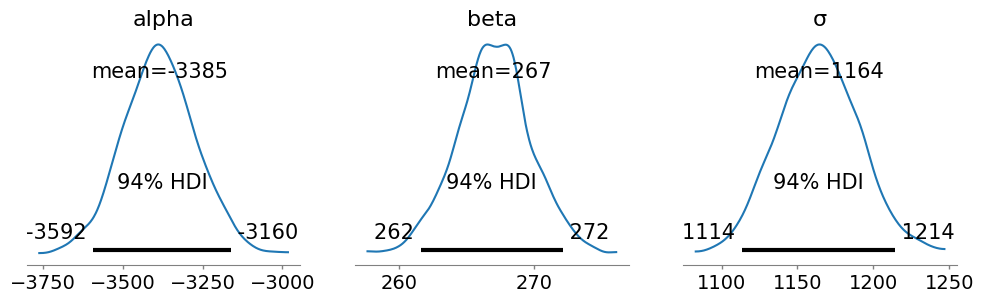

In [ ]:
az.plot_posterior(idata_Sales, var_names=["~μ"], figsize=(12, 3))

In [ ]:
pm.sample_posterior_predictive(idata_Sales, model=Data_rl,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Sales')

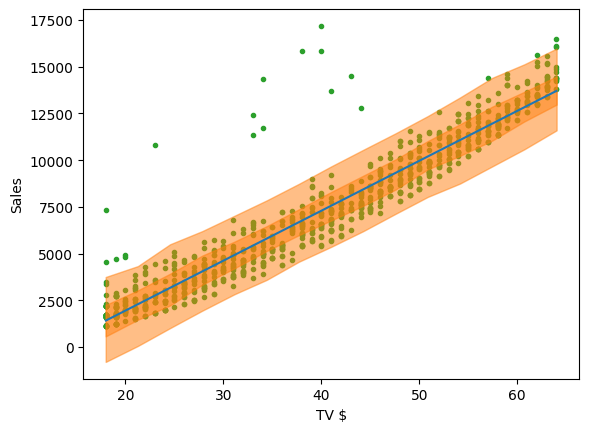

In [ ]:
mean_line = idata_Sales.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
temperatures = np.random.normal(SalesData.age.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_Sales.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(SalesData.age, SalesData.charges, "C2.", zorder=-3)
ax.plot(SalesData.age[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("TV $")
ax.set_ylabel("Sales")


(3000.0, 50000.0)

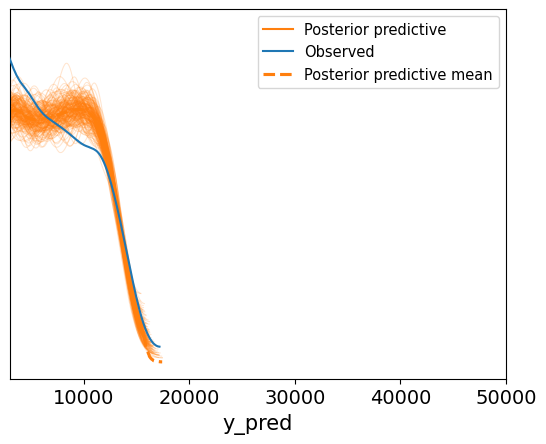

In [ ]:
aa = az.plot_ppc(idata_Sales, num_pp_samples=200, colors=["C1", "C0", "C1"])
aa.set_xlim(3000,50000)

Now looking at this basic model, we see that it does alright. The posterior visualizationsns look good as they line up with the dense line that our data points make. Our posterior predeictive check is also alright. The tail is captured pretty well while the peak is decent at best. During my time with this model and the amount of tweaking I did with the priors, that was the best ppc that I recieved after running the model.

##**Model 2: StudentT**

For this model I just wanted to try out StudentT to maybe see if I can get that tail to be slightly better. The peak at its current point after my testing does not get better at all so what I wanted here was to see if that tail could be even better.

In [ ]:
with pm.Model() as Data_3:
    # Priors for the linear coefficients
    α = pm.Normal("alpha", mu=40000, sigma=5000)  # Intercept with a normal prior
    β = pm.Normal("beta", mu=1000, sigma=500)  # Positive slope with Student's t-distribution prior

    # Linear predictor
    μ = pm.Deterministic("μ", α + β * SalesData['age'])

    # Prior for the standard deviation (σ)
    σ = pm.HalfNormal("σ", sigma=5000)

    # Likelihood using Student’s t-distribution for the observed charges
    y_pred = pm.StudentT("y_pred", mu=μ, sigma=σ, nu=3, observed=SalesData['charges'])

    # Sampling
    idata_Sales3 = pm.sample()

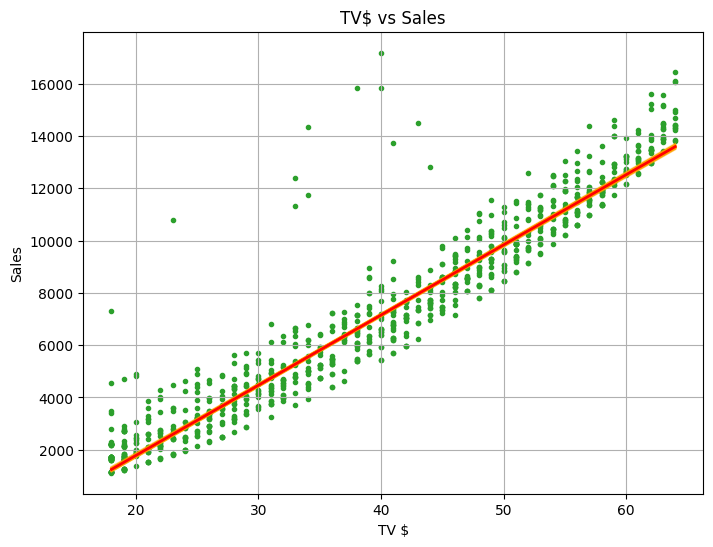

In [ ]:
# Grab 100 posterior samples from the linear regression model
posterior3 = az.extract(idata_Sales3, num_samples=100)

# Generate x values for graphing
x_plot3 = xr.DataArray(
    np.linspace(SalesData.age.min(), SalesData.age.max(), 10),
    dims="plot_id"
)

# Compute the mean regression line (apply sqrt transformation)
mean_line3 = posterior3["alpha"].mean() + posterior3["beta"].mean() * x_plot3

# Generate 100 regression lines from posterior samples (apply sqrt transformation)
lines3 = posterior3["alpha"] + posterior3["beta"] * x_plot3

# Set up the plot
_, ax = plt.subplots(figsize=(8, 6))

# Plot the 100 regression lines from the posterior
ax.plot(x_plot3, lines3.T, c="orange", alpha=0.2)

# Plot the mean regression line
ax.plot(x_plot3, mean_line3, c="red", linewidth=2)

# Scatter plot of raw data
ax.plot(SalesData.age, SalesData.charges, "C2.", zorder=-3)

# Label axes and title
ax.set_xlabel("TV $")
ax.set_ylabel("Sales")
ax.set_title("TV$ vs Sales")
plt.grid(True)
plt.show()


In [ ]:
pm.sample_posterior_predictive(idata_Sales3, model=Data_3,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Sales')

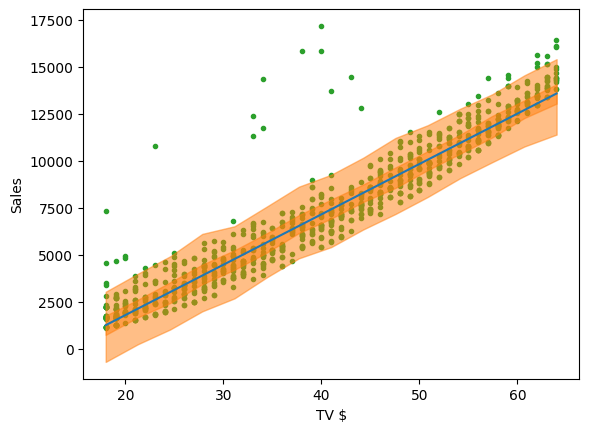

In [ ]:
mean_line = idata_Sales3.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
temperatures = np.random.normal(SalesData.age.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_Sales3.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(SalesData.age, SalesData.charges, "C2.", zorder=-3)
ax.plot(SalesData.age[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("TV $")
ax.set_ylabel("Sales")


(3000.0, 50000.0)

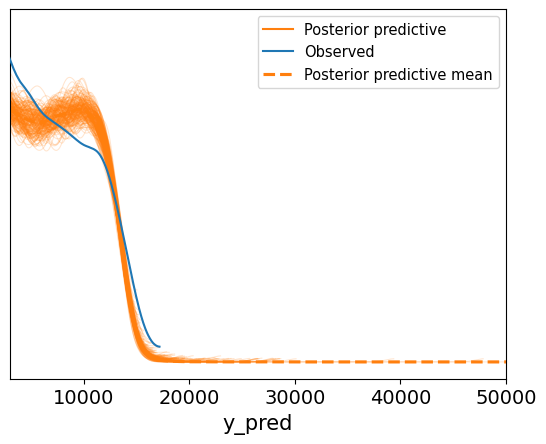

In [ ]:
ab = az.plot_ppc(idata_Sales3, num_pp_samples=200, colors=["C1", "C0", "C1"])
ab.set_xlim(3000,50000)


After creating the StudentT model and switching some prior values, it did not get much better than the normal model. In fact, I think that it got slightly worse. First off just by looking at the posterior predictive check, we can see that the tails got worse instead of getting better. The posterior visualizations also got very slightly worse than what it was before with the Normal model.

##**Model 3: LogNormal**


At this point I used a lot of other models (including exponential) with no prevail. Either they would not work no matter how much I tweaked with it because of values like infinity and negative infinity, or the models that ran would be very, very bad. So now I was onto one of my last options which is the LogNormal model.

In [ ]:
with pm.Model() as Data_im:
    # Priors for the linear coefficients
    α = pm.Normal("alpha", mu=10000, sigma=5000)  # Adjusted to match the scale of charges
    β = pm.Normal("beta", mu=2000, sigma=100)  # Slope, can be positive or negative

    # Linear predictor
    μ = pm.Deterministic("μ", α + β * SalesData['age'])

    # Prior for the standard deviation (σ)
    σ = pm.HalfNormal("σ", sigma=5000)

    # Likelihood using Gamma distribution
    y_pred = pm.LogNormal("y_pred", mu=μ, sigma=σ, observed=SalesData['charges'])

    # Sampling
    idata_Sales2 = pm.sample()

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━  87% 0:00:02 / 0:00:10

In [ ]:
pm.sample_posterior_predictive(idata_Sales2, model=Data_im,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Sales')

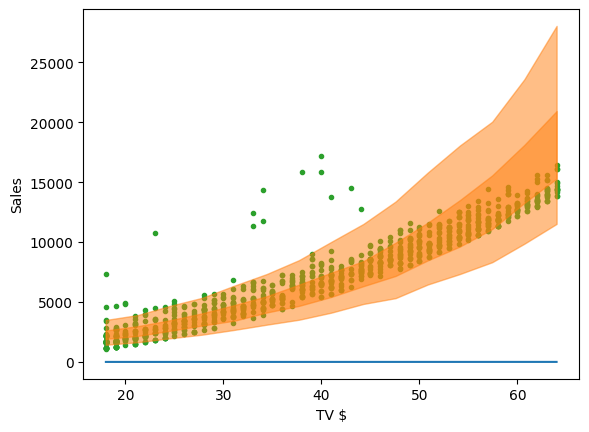

In [ ]:
mean_line = idata_Sales2.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
temperatures = np.random.normal(SalesData.age.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_Sales2.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(SalesData.age, SalesData.charges, "C2.", zorder=-3)
ax.plot(SalesData.age[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("TV $")
ax.set_ylabel("Sales")


(3000.0, 50000.0)

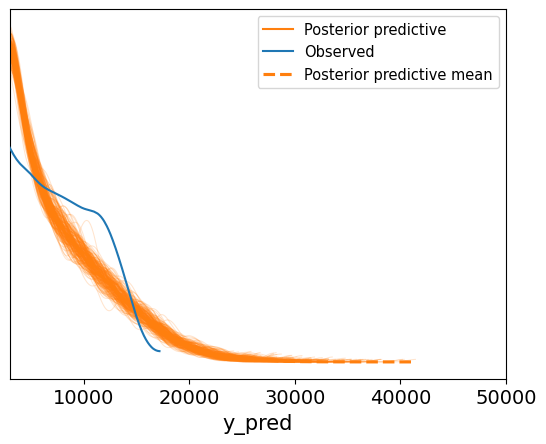

In [ ]:
ab = az.plot_ppc(idata_Sales2, num_pp_samples=200, colors=["C1", "C0", "C1"])
ab.set_xlim(3000,50000)


Now looking at the LogNormal model, we can see that it is completely differnet from the first two. First of all, the posterior visualizations were able to capture the slight curve in the data. Although the spread is not ideal and has room for improvement, just being able to capture that curve very well is something good. However, the posterior predictive check is not that great, there is not that much else to say on it.

After the LogNormal model, I tried combining exponential with StudentT; however, the problem is that i kept on getting negative infinity and infinity values so it did not work.

##**Conclusion**

###**Which was the best model?**

After comparing the three models I built, as well as other variations that I explored but haven't shown, I believe the best model is likely the very first one: the basic Normal model. The StudentT model was very similar to the Normal model in performance but slightly underperformed in comparison. The tail of the StudentT distribution, which I expected to improve the model by better capturing the extreme values, did not lead to a noticeable improvement and, in some cases, worsened the model's fit to the data. The LogNormal model, on the other hand, did a better job at capturing the curve of the data that the Normal model struggled with. However, despite its ability to model the non-linearity of the data, the LogNormal model fell short in two important areas: it didn’t maintain a tight spread, and the posterior predictive check revealed some issues with its general predictive accuracy. Given these considerations, the Normal model's simplicity and better performance on the predictive checks make it the most reliable choice.

---


###**Surprises**
While building and analyzing the models, I encountered some surprising findings related to the data itself. The first surprising observation was that a large number of outliers in the data were individuals who were very young. This was unexpected, as I initially assumed that older individuals would have more outliers due to the increased fluctuations in health risks as people age. Generally, older adults tend to have higher healthcare costs, and their medical needs can fluctuate more due to the development of chronic conditions. However, in this case, a significant portion of the outliers came from younger individuals, which challenges the typical assumption that older individuals are the ones more likely to have extreme medical charges.

The second surprising discovery was related to the drop-off in performance between the Normal and StudentT models. I built the StudentT model expecting it to improve upon the Normal model, particularly by better modeling the heavier tails in the data. I anticipated that the heavier tail would better capture extreme outliers. However, when I ran the model, I observed that the tail behavior actually worsened compared to the Normal model. This result was surprising, as I had expected the StudentT distribution's flexibility to improve the model’s fit to the data, especially with the outliers. Instead, it seems that the extra flexibility didn’t translate to better predictive performance, highlighting the complexity of model selection and the importance of understanding the data distribution before choosing the best model.



---

###**Reality Check**

Now the question that really matters: Does my model reflect reality?

I dont really think so. Since my Normal model is the best model that I have ran for the data, the prediction is linear. In reality, as you grow older and older, you get closer to dying and you have more and more issues with your healty. As you grow older as well, it is harder for you to recover faster from issues and recovery times take longer. Because of all these issues that come with aging, healthcare costs increases. However, my model predicts that the costs increase, so whats the problem? The problem is that my model is linear. Usually when you look at the healthcare insurance costs over time, it increases exponentially due to the exponentially increasing problems and risks that come with aging patients. If my LogNormal model was the best model that ran, then it would reflect reality because it captures the exponential aspect of the of the data.